# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

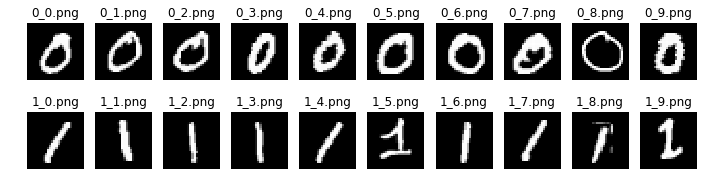

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [176]:
def rotation(angle):
    """2D rotation matrix. Suprised it is not included in numpy
    
    Parameters
    ----------
    angle: Rotation angle
    
    Return
    ------
    2D Rotaion matrix
    """
    return np.matrix([
        [ np.cos(angle), -np.sin(angle) ],
        [ np.sin(angle), np.cos(angle) ]
    ])

def make_meshgrid(x, y, h=.02, padding=0.1):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - padding, x.max() + padding
    y_min, y_max = y.min() - padding, y.max() + padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def get_contours(im):
    cont = find_contours(im, 0)
    cont[0] = (rotation(0) * cont[0].T).T
    cont[0] = np.flip(cont[0], 1)
    return cont[0]

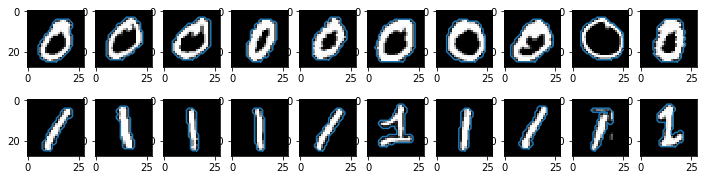

In [177]:
from skimage.measure import find_contours
from numpy.fft import fft

fig, ax = plt.subplots(2, len(zeros_im), figsize=(12, 3))

# Original image
ims = [zeros_im, ones_im]
fd_inv = []
for num in range(len(ims)):
    fd_inv.append(np.zeros((len(ims[num]), 2)))
    
    for i in range(len(ims[num])):
        # Contours
        cont = get_contours(ims[num][i])
        ax[num, i].imshow(ims[num][i], cmap='gray')
        ax[num, i].plot(cont[:, 0], cont[:, 1])

        # DFT
        sing_cont = [ np.complex(n[0, 0], n[0, 1]) for n in cont ]
        fd = fft(sing_cont)
        fd_ref = abs(fd[1])

        for j in range(2):
            fd_inv[num][i, 0]
            fd_inv[num][0, j]
            fd_inv[num][i, j] = abs(fd[j + 2]) / fd_ref

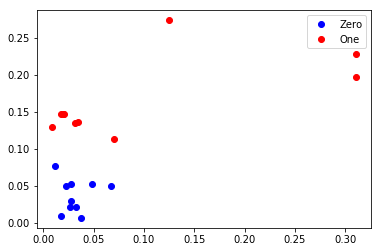

In [178]:
plt.plot(fd_inv[0][:, 0], fd_inv[0][:, 1], marker='o', lw=0, color='blue', label='Zero')
plt.plot(fd_inv[1][:, 0], fd_inv[1][:, 1], marker='o', lw=0, color='red', label='One')
plt.legend()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


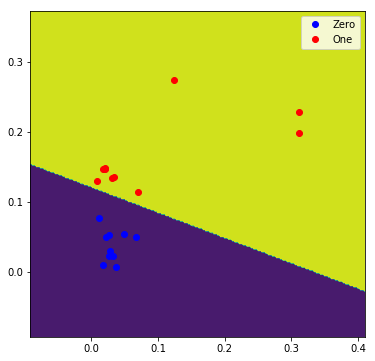

In [179]:
from sklearn import svm

X = np.concatenate((fd_inv[0], fd_inv[1]))
y = [0]*len(fd_inv[0]) + [1]*len(fd_inv[1]) 


clf = svm.LinearSVC()
clf.fit(X, y)  

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1, h=0.002)
plot_contours(ax, clf, xx, yy)

ax.plot(fd_inv[0][:, 0], fd_inv[0][:, 1], marker='o', lw=0, color='blue', label='Zero')
ax.plot(fd_inv[1][:, 0], fd_inv[1][:, 1], marker='o', lw=0, color='red', label='One')
ax.legend()

print(res)

# TODO
- Augment data (rotation + translation)
- Split on test and training, implement F-folds
- Experiment with more features (we can try with 3 and draw 3D plot)
- Different classification methods
    - SVM
    - LinearSVM
    - GMM
- Contour detection methods
    - Curve Polygonalisation
    - Morphological Skeleton
- Implement
    - Distance between two contours
    - Chain code (Freeman code + Fisher-Wagner algorithm)

### 1.3 Additional method(s)
Add your implementation and discussion